# Notebook to Visualize Misclassifications

## 1. Import Libraries

In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import random
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.stats import kurtosis
from scipy.stats import skew

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset
import torch.cuda as cutorch

#Import User defined classes
from AweNoise.models.torch_models import SimpleNet, SimpleNet_with_dropout, SiameseNet
from AweNoise.torch_utils import evaluate_model,test_classifier, baseline, accuracy
from AweNoise.datasets import CNN_dataset, SiameseTriplets

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



## 2. Data Loading and Common Functions

In [2]:
clean_ds = CNN_dataset(split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = np.Inf, k = np.Inf, cluster = False)

KeyboardInterrupt: 

In [ ]:
clean_num_to_word, clean_word_to_num = clean_ds.num_to_word.copy(),clean_ds.word_to_num.copy()
del clean_ds

In [ ]:
#Load the clean AWEs
clean_awe_embeddings_dict = np.load("C:/Users/jayes/Downloads/LSV/Data/word_embedding_dict_latest.npy", allow_pickle = True).item()


In [ ]:
#Construct a list of word labels and their embeddings
clean_awe_words = []
clean_awe_embeddings = []

for word, awe in clean_awe_embeddings_dict.items():
    clean_awe_words.append(word)
    clean_awe_embeddings.append(awe.squeeze())

clean_awe_embeddings = np.stack(clean_awe_embeddings)

print(len(clean_awe_words))
print(clean_awe_embeddings.shape)



In [ ]:
#Construct a Nearest Neighbour object for querying later
neigh = NearestNeighbors( metric = 'cosine', n_jobs = -1)
neigh.fit(clean_awe_embeddings)

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def nearest_clean_awe(embeddings):
    '''Find the nearest clean embedding of the given embedding and return the word label'''
    
    #Calculate cosine distance between the embedding and all the clean embeddings
    #distances = pairwise_distances(embeddings, clean_awe_embeddings, metric = 'cosine')
    #labels = np.argmin(distances, axis = 1)
    
    word_indices = neigh.kneighbors(embeddings, 1, False)
    
    nearest_clean_words = [clean_awe_words[word_indices[i][0]] for i in range(word_indices.shape[0])]
    
    return nearest_clean_words
    
    

In [ ]:
def clean_mapping(yb):
    mapped_yb = [clean_word_to_num[test_ds.num_to_word[yb[i].item()]] for i in range(yb.shape[0])]
    mapped_yb = torch.tensor(mapped_yb)
    
    return mapped_yb

In [ ]:
def load_test(snr = np.Inf):
    '''Function to load test data of a given snr'''
    bs = 64
    #Test Dataset
    test_ds = CNN_dataset(split_set = "test", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = np.Inf, cluster = False)
    #Dataloaders
    test_dl = DataLoader(test_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = True)
    
    print(len(test_ds.num_to_word.keys()),len(clean_num_to_word))
    print(test_ds.num_to_word == clean_num_to_word)
    
    return test_ds,test_dl

In [ ]:
def load_model(num_output):
    '''Function to create a model given number of outputs, and load weights'''
    
    #CNN
    net = SimpleNet(num_output)
    net = net.float()
    net.to(dev)
    
    model_save_path = "C:/Users/jayes/Downloads/LSV/Models/cnn_clean.pth"
    #Load model weights
    net.load_state_dict(torch.load(model_save_path))
    
    return net

In [ ]:
def predict_on_test(net, test_dl):
    '''Function to predict on a given test set'''
    word_to_pred = {}
    word_to_nn = {} #Word to nearest neighbour
    test_acc = 0
    y_pred_labels = None
    for xb,yb in test_dl:
        #Transform yb to clean mappings
        yb = clean_mapping(yb)

        #Move to GPU
        xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
        y_pred = net(xb)
        y_embed = net.give_embeddings(xb, dev)
        y_nn_awe = nearest_clean_awe(y_embed)
        
        test_acc += accuracy(y_pred,yb.long())
        
        #Add it to y_pred_with_labels
        if y_pred_labels is None:
            y_pred_labels = np.concatenate((yb.cpu().detach().numpy().reshape(-1,1),y_pred.cpu().detach().numpy()), axis = 1)
        else:
            curr_y_pred_labels = np.concatenate((yb.cpu().detach().numpy().reshape(-1,1),y_pred.cpu().detach().numpy()), axis = 1)
            y_pred_labels = np.concatenate((y_pred_labels, curr_y_pred_labels))
        


        for i in range(y_pred.shape[0]):
            word = clean_num_to_word[yb[i].item()]
            pred = clean_num_to_word[torch.argmax(y_pred[i]).item()]

            if word in word_to_pred.keys():
                word_to_pred[word].append(pred)
            else:
                word_to_pred[word] = [pred]
            
            if word in word_to_nn.keys():
                word_to_nn[word].append(y_nn_awe[i])
            else:
                word_to_nn[word] = [y_nn_awe[i]]

    test_acc = test_acc/len(test_dl)

    print("Test Accuracy ", test_acc.item())
    
    return word_to_pred, word_to_nn, y_pred_labels

## 3. Prediction

In [13]:
#Load Best Clean Model
num_output = len(clean_num_to_word.keys()) #Num output is same as clean dataset
net = load_model(num_output)

In [24]:
snr_values = [np.Inf, 20, 5, 0 , -5]

for snr in snr_values:
    #Load test data
    test_ds,test_dl = load_test(snr = snr)
    #predict on test data
    word_to_pred, word_to_nn, y_pred_labels = predict_on_test(net, test_dl)
    
    #Save word_to_pred and y_pred
    
    if snr < np.Inf:
        #np.save('Data/snr%d_word_to_pred.npy'%(snr), word_to_pred)
        np.save('C:/Users/jayes/Downloads/LSV/Data/snr%d_word_to_nn.npy'%(snr), word_to_nn)
        #np.save('Data/snr%d_y_pred_labels.npy'%(snr), y_pred_labels)
    else:
        #np.save('Data/clean_word_to_pred.npy', word_to_pred)
        np.save('C:/Users/jayes/Downloads/LSV/Data//clean_word_to_nn.npy', word_to_nn)
        #np.save('Data/clean_y_pred_labels.npy', y_pred_labels)
    
    del word_to_pred, y_pred_labels, test_ds,test_dl

Length before filtering on char length 169383
Length after filtering on char length 80821
Finished Loading the Data, 80821 examples
Number of Unique words  8607
Length before filtering on frequency_bounds  (80821,)
Not filtering
(48492, 40, 100) (16164, 40, 100) (16165, 40, 100)
8607 8607
True
Test Accuracy  0.350508451461792
Length before filtering on char length 169343
Length after filtering on char length 80810
Finished Loading the Data, 80810 examples
Number of Unique words  8606
Length before filtering on frequency_bounds  (80810,)
Not filtering
(48486, 40, 100) (16162, 40, 100) (16162, 40, 100)
8606 8607
False
Test Accuracy  0.211123526096344
Length before filtering on char length 169299
Length after filtering on char length 80781
Finished Loading the Data, 80781 examples
Number of Unique words  8606
Length before filtering on frequency_bounds  (80781,)
Not filtering
(48468, 40, 100) (16156, 40, 100) (16157, 40, 100)
8606 8607
False
Test Accuracy  0.01289682649075985
Length befor

## 4. Visualization

In [2]:
import sfba4
from sfba4.utils import alignSequences

In [3]:
#Load the word phoneme dict
word_phoneme_dict = np.load("C:/Users/jayes/Downloads/LSV/Data/word_phoneme_dict.npy", allow_pickle = True).item()

In [4]:
word_phoneme_dict

{'pixel': 'P IH K S AH L',
 'finds': 'F AY N D Z',
 'echelons': 'EH SH AH L AA N Z',
 'suppo': 'S UW P OW',
 'brick': 'B R IH K',
 'smallish': 'S M AO L IH SH',
 'execute': 'EH K S AH K Y UW T',
 'ignore': 'IH G N AO R',
 'doesnt': 'D OW S AH N T',
 'injury': 'IH N JH ER IY',
 'lowering': 'L OW ER IH NG',
 'innova': 'IH N OW V AH',
 'horses': 'HH AO R S AH Z',
 'atmosphere': 'AE T M AH S F IH R',
 'kangaroo': 'K AE NG G ER UW',
 'preparing': 'P R IY P EH R IH NG',
 'refining': 'R AH F AY N IH NG',
 'hypothetically': 'HH AY P AH TH EH T IH K L IY',
 'beams': 'B IY M Z',
 'sucking': 'S AH K IH NG',
 'arbitrarily': 'AA R B IH T R EH R AH L IY',
 'teambuilding': 'T IY M B IH L D IH NG',
 'semisuperv': 'S EH M IY S UW P ER V',
 'lefthander': 'L EH F T HH AE N D ER',
 'assignments': 'AH S AY N M AH N T S',
 'script': 'S K R IH P T',
 'decision': 'D IH S IH ZH AH N',
 'candidates': 'K AE N D AH D EY T S',
 'fruitful': 'F R UW T F AH L',
 'redundancy': 'R IH D AH N D AH N S IY',
 'conformable'

In [5]:
alignSequences.align(word_phoneme_dict["pixel"],word_phoneme_dict["finds"])

('P IH K S AH L', '- F AY N D Z', 6)

In [6]:
#Load word pred dictionaries
snr_strings = ["clean"] + ["snr%d"%(snr) for snr in [20,5,0,-5] ]
word_to_pred_dicts = {}
word_to_nn_dicts = {}
y_pred_labels_matrices = []
for snr_string in snr_strings:
    word_to_pred_dicts[snr_string] = np.load("C:/Users/jayes/Downloads/LSV/Data/%s_word_to_pred.npy"%(snr_string), allow_pickle = True).item()
    word_to_nn_dicts[snr_string] = np.load("C:/Users/jayes/Downloads/LSV/Data/%s_word_to_nn.npy"%(snr_string), allow_pickle = True).item()
    

In [7]:
pred_edit_distances_dict = {}
nn_edit_distances_dict = {}
for snr_string,word_to_pred_dict in word_to_pred_dicts.items():
    pred_edit_distances_dict[snr_string] = []
    for test_word,predicted_words in word_to_pred_dict.items():
        for predicted_word in predicted_words:
            aligned_seq1, aligned_seq2, eDistance = alignSequences.align(word_phoneme_dict[test_word], word_phoneme_dict[predicted_word])
            pred_edit_distances_dict[snr_string].append(eDistance)

for snr_string,word_to_nn_dict in word_to_nn_dicts.items():
    nn_edit_distances_dict[snr_string] = []
    for test_word,nn_words in word_to_nn_dict.items():
        for nn_word in nn_words:
            aligned_seq1, aligned_seq2, eDistance = alignSequences.align(word_phoneme_dict[test_word], word_phoneme_dict[nn_word])
            nn_edit_distances_dict[snr_string].append(eDistance)

Text(0, 0.5, 'Frequency')

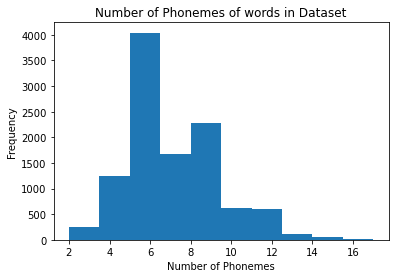

In [8]:
phoneme_lens = [len(val.split()) for key,val in word_phoneme_dict.items()]
plt.hist(phoneme_lens)
plt.title("Number of Phonemes of words in Dataset")
plt.xlabel("Number of Phonemes")
plt.ylabel("Frequency")

In [20]:
def filter_zeros(edit_distances):
    edit_distances = [val for val in edit_distances if val!= 0 ]
    
    return edit_distances

In [10]:
def give_skew_and_kurt(edit_distances):
    
    curr_skew = skew(filter_zeros(edit_distances))
    curr_kurt = kurtosis(filter_zeros(edit_distances))
    
    return curr_skew, curr_kurt

In [11]:
snr_string = "snr-5"
print(kurtosis(filter_zeros(pred_edit_distances_dict[snr_string])))
print(skew(filter_zeros(pred_edit_distances_dict[snr_string])))

0.6329391447371613
0.33991491853192984


Text(0, 0.5, 'Frequency')

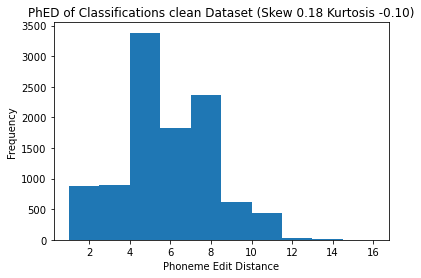

In [12]:
snr_string = "clean"
plt.hist(filter_zeros(pred_edit_distances_dict[snr_string]))
curr_skew, curr_kurt = give_skew_and_kurt(pred_edit_distances_dict["clean"])
plt.title("PhED of Classifications %s Dataset (Skew %.2f Kurtosis %.2f)"%(snr_string, curr_skew, curr_kurt))
plt.xlabel("Phoneme Edit Distance")
plt.ylabel("Frequency")

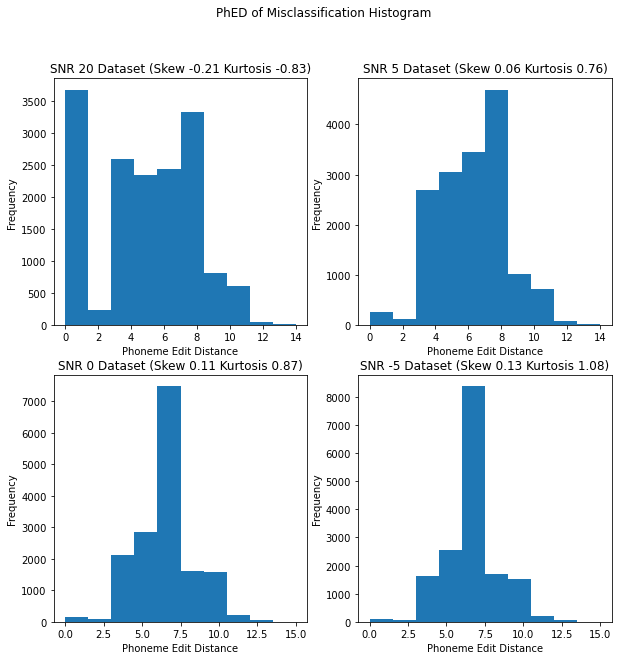

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('PhED of Misclassification Histogram')

#SNR 20
axs[0, 0].hist(filter_zeros(pred_edit_distances_dict["snr20"]))
curr_skew, curr_kurt = give_skew_and_kurt(pred_edit_distances_dict["snr20"])
axs[0, 0].set_title('SNR 20 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR 5
axs[0, 1].hist(filter_zeros(pred_edit_distances_dict["snr5"]))
curr_skew, curr_kurt = give_skew_and_kurt(pred_edit_distances_dict["snr5"])
axs[0, 1].set_title('SNR 5 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR 0
axs[1, 0].hist(filter_zeros(pred_edit_distances_dict["snr0"]))
curr_skew, curr_kurt = give_skew_and_kurt(pred_edit_distances_dict["snr0"])
axs[1, 0].set_title('SNR 0 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR -5
axs[1, 1].hist(filter_zeros(pred_edit_distances_dict["snr-5"]))
curr_skew, curr_kurt = give_skew_and_kurt(pred_edit_distances_dict["snr-5"])
axs[1, 1].set_title('SNR -5 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#x,y labels
for ax in axs.flat:
    ax.set(xlabel='Phoneme Edit Distance', ylabel='Frequency')

plt.savefig("misclassification_histogram.png")

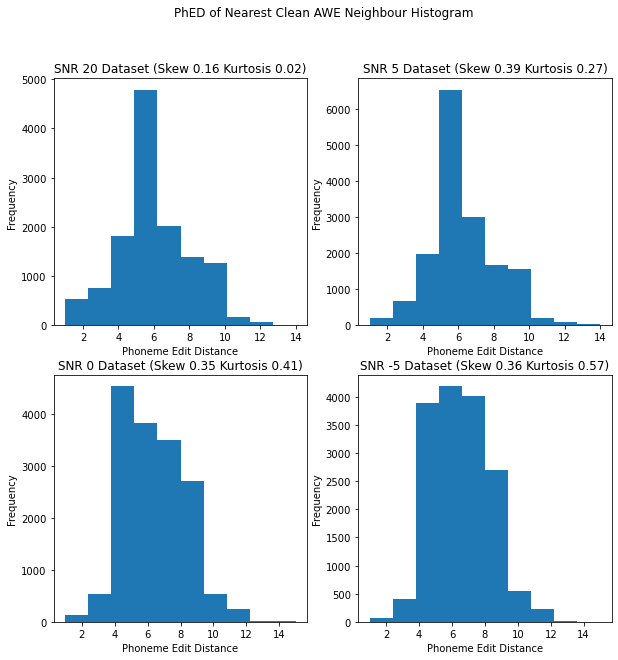

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('PhED of Nearest Clean AWE Neighbour Histogram')

#SNR 20
axs[0, 0].hist(filter_zeros(nn_edit_distances_dict["snr20"]))
curr_skew, curr_kurt = give_skew_and_kurt(nn_edit_distances_dict["snr20"])
axs[0, 0].set_title('SNR 20 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR 5
axs[0, 1].hist(filter_zeros(nn_edit_distances_dict["snr5"]))
curr_skew, curr_kurt = give_skew_and_kurt(nn_edit_distances_dict["snr5"])
axs[0, 1].set_title('SNR 5 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR 0
axs[1, 0].hist(filter_zeros(nn_edit_distances_dict["snr0"]))
curr_skew, curr_kurt = give_skew_and_kurt(nn_edit_distances_dict["snr0"])
axs[1, 0].set_title('SNR 0 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#SNR -5
axs[1, 1].hist(filter_zeros(nn_edit_distances_dict["snr-5"]))
curr_skew, curr_kurt = give_skew_and_kurt(nn_edit_distances_dict["snr-5"])
axs[1, 1].set_title('SNR -5 Dataset (Skew %.2f Kurtosis %.2f)'%(curr_skew, curr_kurt))

#x,y labels
for ax in axs.flat:
    ax.set(xlabel='Phoneme Edit Distance', ylabel='Frequency')

plt.savefig("nearest_clean_awe_histogram.png")

## 5. Update Word Phoneme Dict

In [41]:
from big_phoney import BigPhoney

Using TensorFlow backend.


In [42]:
def filter_alphabets(string):
    return ''.join(e for e in string if (e.isalpha() or e.isspace()))

In [43]:
phoney = BigPhoney()

In [52]:
count = 0
for key in clean_word_to_num.keys():

    if key not in word_phoneme_dict.keys():
        print("Adding %s Count %d"%(key,count))
        word_phoneme_dict[key] = filter_alphabets(phoney.phonize(key))
        count+= 1

print(count)

Adding tfidf Count 0
Adding bdboo Count 1
Adding nlssd Count 2
Adding tdidf Count 3
Adding spnlp Count 4
Adding ctiio Count 5
Adding xhtml Count 6
Adding antirsi Count 7
Adding importantcause Count 8
Adding idvidnme Count 9
Adding preferencesyeah Count 10
Adding apogee Count 11
Adding mailbox Count 12
Adding reasearch Count 13
Adding cupboards Count 14
Adding southwest Count 15
Adding sunrise Count 16
Adding northeast Count 17
Adding sunset Count 18
Adding marianne Count 19
Adding mariannes Count 20
Adding gisella Count 21
Adding humanly Count 22
Adding courtyard Count 23
Adding reserving Count 24
Adding cafeterias Count 25
Adding stagieur Count 26
Adding bookshelves Count 27
Adding minilibrary Count 28
Adding collegues Count 29
Adding mountains Count 30
Adding mailboxes Count 31
Adding stagieurs Count 32
Adding orienting Count 33
Adding bathrooms Count 34
Adding elevators Count 35
Adding professors Count 36
Adding administrators Count 37
Adding networked Count 38
Adding printers Count

Adding notably Count 324
Adding thriller Count 325
Adding actiony Count 326
Adding cesar Count 327
Adding showings Count 328
Adding violently Count 329
Adding normandy Count 330
Adding filmed Count 331
Adding anonymously Count 332
Adding greyish Count 333
Adding darkish Count 334
Adding uniforms Count 335
Adding weapons Count 336
Adding resentful Count 337
Adding christian Count 338
Adding funnier Count 339
Adding treatment Count 340
Adding enjoyable Count 341
Adding freer Count 342
Adding spans Count 343
Adding evadees Count 344
Adding poignant Count 345
Adding clubbers Count 346
Adding boxer Count 347
Adding statistically Count 348
Adding deniss Count 349
Adding darabont Count 350
Adding freshest Count 351
Adding victory Count 352
Adding starling Count 353
Adding hannibal Count 354
Adding simulati Count 355
Adding shawshank Count 356
Adding trivias Count 357
Adding advertisements Count 358
Adding sleepi Count 359
Adding dufresne Count 360
Adding witnesses Count 361
Adding horrors Cou

Adding pedagogical Count 635
Adding visuali Count 636
Adding visualising Count 637
Adding disappearing Count 638
Adding historically Count 639
Adding exhale Count 640
Adding extending Count 641
Adding subprojects Count 642
Adding localization Count 643
Adding distributing Count 644
Adding mirroring Count 645
Adding electret Count 646
Adding omnidirectional Count 647
Adding selfregulating Count 648
Adding normative Count 649
Adding accesi Count 650
Adding peripher Count 651
Adding peripherical Count 652
Adding distant Count 653
Adding approximatively Count 654
Adding solidity Count 655
Adding richer Count 656
Adding counterintuitive Count 657
Adding radians Count 658
Adding occupying Count 659
Adding prolongating Count 660
Adding inherent Count 661
Adding intersect Count 662
Adding dominant Count 663
Adding instantaneous Count 664
Adding negligible Count 665
Adding timbre Count 666
Adding francais Count 667
Adding females Count 668
Adding energetic Count 669
Adding smoothing Count 670
A

In [53]:
word_phoneme_dict['funnier']

'F AH N IY ER'

In [54]:
#save updated word phoneme dict
np.save("Data/word_phoneme_dict.npy", word_phoneme_dict)

End Of Training Cells